In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "CPP"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn014051,MGEERERESESESEACGRGGPVMDTPVRNQIAAPGSQFEESPVFNY...,773,1
1,Achn050881,MEVNDSATKEQKPCKCKQSRCVKLYCECFSSGTYCEGCRCINCQNN...,389,1
2,Achn065621,MGQSVFGLLRGCERWGLGRKGATAAEGCENFGLRSGTAHKDEFNCL...,345,1
3,Achn069971,MYQMNLREGFRNSSHKEIYIYKYISIKSCPFIGSPITSNSPKSTTN...,639,1
4,Achn146311,MEKGEGGDFSPKTDQSDTLPDFPAKKLARQLDFTGFSGASGTVVLP...,553,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
1746,0.019447,0.000000,0.001024,0.002047,0.000000,0.006141,0.000000,0.008188,0.001024,0.011259,...,0.001024,0.001024,0.000000,0.001024,0.001024,0.002047,0.0,0.0,0.0,0.000000
2293,0.004320,0.002160,0.006479,0.000000,0.000000,0.002160,0.002160,0.002160,0.004320,0.004320,...,0.000000,0.000000,0.002160,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
1549,0.011765,0.001681,0.005042,0.003361,0.001681,0.001681,0.001681,0.003361,0.005042,0.006723,...,0.000000,0.000000,0.000000,0.001681,0.001681,0.000000,0.0,0.0,0.0,0.000000
2672,0.000000,0.002506,0.002506,0.007519,0.002506,0.000000,0.000000,0.005013,0.000000,0.000000,...,0.000000,0.002506,0.002506,0.000000,0.002506,0.000000,0.0,0.0,0.0,0.005013
872,0.021452,0.000000,0.001650,0.003300,0.001650,0.011551,0.000000,0.006601,0.003300,0.004950,...,0.000000,0.000000,0.000000,0.003300,0.003300,0.001650,0.0,0.0,0.0,0.000000


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2558, 441)
X_test: (640, 441)
y_train: (2558,)
y_test: (640,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 19s 628ms/step - accuracy: 0.5156 - loss: 0.6934

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6451 - loss: 0.6865   

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6669 - loss: 0.6832 - val_accuracy: 0.9590 - val_loss: 0.5548


Epoch 2/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9531 - loss: 0.5536

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9644 - loss: 0.4219 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9645 - loss: 0.4138 - val_accuracy: 0.9707 - val_loss: 0.0988


Epoch 3/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9688 - loss: 0.0897

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9800 - loss: 0.0681 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9801 - loss: 0.0677 - val_accuracy: 0.9766 - val_loss: 0.0711


Epoch 4/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0127

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9888 - loss: 0.0360 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9886 - loss: 0.0363 - val_accuracy: 0.9844 - val_loss: 0.0521


Epoch 5/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0174

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9919 - loss: 0.0209 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9921 - loss: 0.0206 - val_accuracy: 0.9590 - val_loss: 0.0864


Epoch 6/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0156

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9856 - loss: 0.0382 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9858 - loss: 0.0375 - val_accuracy: 0.9785 - val_loss: 0.0741


Epoch 7/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0027

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0169 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0164 - val_accuracy: 0.9785 - val_loss: 0.0570


Epoch 8/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0108

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0061 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0059 - val_accuracy: 0.9844 - val_loss: 0.0480


Epoch 9/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0046

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0043 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0042 - val_accuracy: 0.9863 - val_loss: 0.0475


Epoch 10/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0073

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0058 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0057 - val_accuracy: 0.9844 - val_loss: 0.0521


Epoch 11/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 6.8864e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0014     

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9824 - val_loss: 0.0534


Epoch 12/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 5.4799e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0019     

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0019 - val_accuracy: 0.9805 - val_loss: 0.0609


Epoch 13/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 8.5512e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0017     

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9844 - val_loss: 0.0539


Epoch 14/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 4.7534e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 7.5362e-04 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 7.4045e-04 - val_accuracy: 0.9844 - val_loss: 0.0546


Epoch 15/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 1.0898e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.9603e-04 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 5.0040e-04 - val_accuracy: 0.9824 - val_loss: 0.0572


Epoch 16/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 4.2846e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0015     

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9805 - val_loss: 0.1318


Epoch 17/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0347

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0076 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0075 - val_accuracy: 0.9824 - val_loss: 0.0802


Epoch 18/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 2.1173e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0106     

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0103 - val_accuracy: 0.9766 - val_loss: 0.0776


Epoch 19/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 8.2675e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0026     

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0026 - val_accuracy: 0.9863 - val_loss: 0.0534



[Train Accuracy: 99.90% - Test Accuracy: 99.22%]


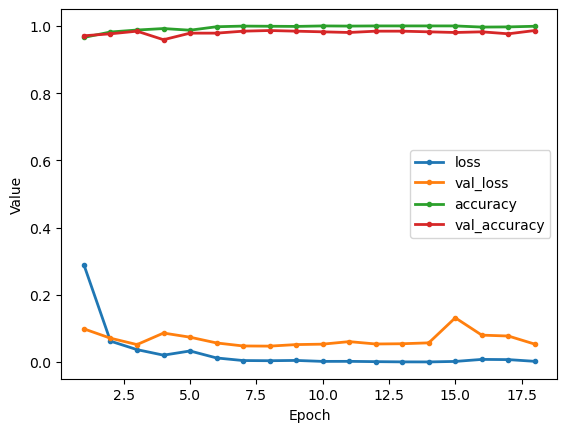

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
1746,0.006148,0.0,0.0,0.0,0.0,0.000000,0.0,0.002049,0.000000,0.003074,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2293,0.000000,0.0,0.0,0.0,0.0,0.002165,0.0,0.000000,0.002165,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1549,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.001684,0.000000,0.001684,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2672,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.002513,0.0,0.002513,0.0,0.0,0.0,0.0,0.0
872,0.008264,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.003306,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2558, 8639)
X_test: (640, 8639)
y_train: (2558,)
y_test: (640,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,211,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,255,105 (8.60 MB)

 Trainable params: 2,255,105 (8.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 19s 640ms/step - accuracy: 0.3906 - loss: 0.6932

 8/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5027 - loss: 0.6928   

15/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4954 - loss: 0.6932

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4942 - loss: 0.6929

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4945 - loss: 0.6921

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4950 - loss: 0.6918 - val_accuracy: 0.6680 - val_loss: 0.6611


Epoch 2/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6250 - loss: 0.6657

 8/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6747 - loss: 0.6535 

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7213 - loss: 0.6380

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7496 - loss: 0.6163

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7730 - loss: 0.5921

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7756 - loss: 0.5892 - val_accuracy: 0.9395 - val_loss: 0.3117


Epoch 3/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9531 - loss: 0.2986

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9805 - loss: 0.2353 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9831 - loss: 0.2089

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9848 - loss: 0.1871

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9861 - loss: 0.1690 - val_accuracy: 0.9707 - val_loss: 0.0880


Epoch 4/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0137

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9945 - loss: 0.0291 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9960 - loss: 0.0236

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9966 - loss: 0.0206

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9969 - loss: 0.0190 - val_accuracy: 0.9863 - val_loss: 0.0384


Epoch 5/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0056

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9977 - loss: 0.0080 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9982 - loss: 0.0066

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9986 - loss: 0.0058

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9988 - loss: 0.0052 - val_accuracy: 0.9863 - val_loss: 0.0273


Epoch 6/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0015

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9985 - loss: 0.0026 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9975 - loss: 0.0035

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9976 - loss: 0.0035

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9976 - loss: 0.0034 - val_accuracy: 0.9746 - val_loss: 0.0863


Epoch 7/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 7.3878e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011     

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0013

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0012

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9902 - val_loss: 0.0249


Epoch 8/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.9684e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4723e-04 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4842e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4998e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.6449e-04 - val_accuracy: 0.9883 - val_loss: 0.0284


Epoch 9/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.4877e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.0798e-04 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2320e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.1803e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.0706e-04 - val_accuracy: 0.9863 - val_loss: 0.0426


Epoch 10/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.0166e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5200e-04 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2824e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.1264e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.0581e-04 - val_accuracy: 0.9863 - val_loss: 0.0361


Epoch 11/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 7.6840e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5581e-04 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9844e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8103e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.6999e-04 - val_accuracy: 0.9844 - val_loss: 0.0453


Epoch 12/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 4.9482e-05

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.0106e-04 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9653e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2319e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.3268e-04 - val_accuracy: 0.9863 - val_loss: 0.0346


Epoch 13/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 4.5108e-05

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.9587e-05 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.6317e-05

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.1985e-05

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.7939e-05 - val_accuracy: 0.9863 - val_loss: 0.0318


Epoch 14/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 8.2704e-05

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8465e-04 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6638e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5014e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3991e-04 - val_accuracy: 0.9863 - val_loss: 0.0352


Epoch 15/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.3333e-05

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8603e-04 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5471e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5775e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.8081e-04 - val_accuracy: 0.9941 - val_loss: 0.0127


Epoch 16/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 1.8337e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9570e-04 

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4796e-04

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3362e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2083e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.1747e-04 - val_accuracy: 0.9844 - val_loss: 0.0463


Epoch 17/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 5.2293e-05

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6138e-05 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.1339e-05

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.8533e-05

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.0433e-05 - val_accuracy: 0.9844 - val_loss: 0.0443


Epoch 18/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 4.8147e-05

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.8984e-05 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9171e-05

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9111e-05

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.9682e-05 - val_accuracy: 0.9863 - val_loss: 0.0373


Epoch 19/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.0056e-05

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.4420e-05 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.9554e-05

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.6884e-05

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.5272e-05 - val_accuracy: 0.9883 - val_loss: 0.0337


Epoch 20/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.9034e-05

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9519e-05 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.5991e-05

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.4503e-05

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.2935e-05 - val_accuracy: 0.9883 - val_loss: 0.0365


Epoch 21/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.7991e-05

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5081e-05 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7850e-05

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2397e-05

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.4682e-05 - val_accuracy: 0.9844 - val_loss: 0.0386


Epoch 22/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.1710e-05

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4918e-05 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.1150e-05

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.3111e-05

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.5257e-05 - val_accuracy: 0.9863 - val_loss: 0.0385


Epoch 23/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.7615e-05

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.2852e-05 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.0043e-05

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.6545e-05

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.6110e-05 - val_accuracy: 0.9883 - val_loss: 0.0355


Epoch 24/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 6.5042e-06

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.3782e-05 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.5293e-05

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.5804e-05

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.7733e-05 - val_accuracy: 0.9844 - val_loss: 0.0577


Epoch 25/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.3998e-05

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8939e-05 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1543e-05

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.1596e-05

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.6314e-05 - val_accuracy: 0.9902 - val_loss: 0.0210



[Train Accuracy: 100.00% - Test Accuracy: 99.22%]


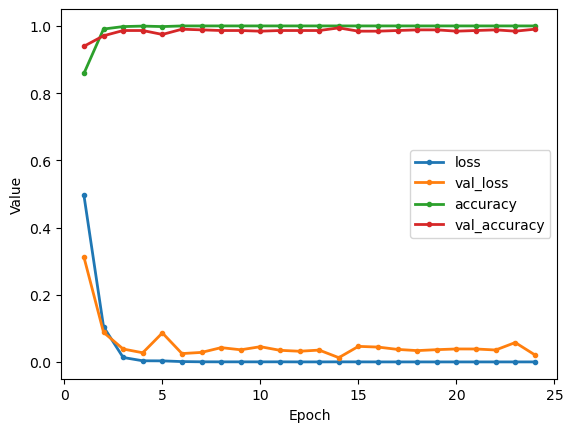

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
1746,0.002051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2293,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1549,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2672,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
872,0.006623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      34,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,139,393 (130.23 MB)

 Trainable params: 34,139,393 (130.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 27s 894ms/step - accuracy: 0.5625 - loss: 0.6931

 2/32 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.5703 - loss: 0.6931 

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.5608 - loss: 0.6931

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.5534 - loss: 0.6931

 5/32 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.5496 - loss: 0.6930

 6/32 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.5478 - loss: 0.6930

 7/32 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.5461 - loss: 0.6929

 8/32 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.5442 - loss: 0.6928

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.5436 - loss: 0.6927

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.5420 - loss: 0.6927

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.5408 - loss: 0.6926

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.5391 - loss: 0.6925

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.5374 - loss: 0.6924

14/32 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.5353 - loss: 0.6924

15/32 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.5331 - loss: 0.6923

16/32 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.5318 - loss: 0.6922

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.5315 - loss: 0.6921

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.5320 - loss: 0.6920

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.5334 - loss: 0.6919

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.5354 - loss: 0.6918

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.5378 - loss: 0.6916

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.5404 - loss: 0.6914

23/32 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.5430 - loss: 0.6912

24/32 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.5457 - loss: 0.6910

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.5482 - loss: 0.6908

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.5508 - loss: 0.6905

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.5535 - loss: 0.6903

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.5562 - loss: 0.6900

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.5591 - loss: 0.6896

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.5620 - loss: 0.6893

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.5650 - loss: 0.6889

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.5681 - loss: 0.6886

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - accuracy: 0.5710 - loss: 0.6882 - val_accuracy: 0.9590 - val_loss: 0.6123


Epoch 2/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 8s 289ms/step - accuracy: 0.9531 - loss: 0.6077

 2/32 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.9531 - loss: 0.6053

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9583 - loss: 0.6022

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9609 - loss: 0.5991

 5/32 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9625 - loss: 0.5963

 6/32 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9622 - loss: 0.5937

 7/32 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9625 - loss: 0.5906

 8/32 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9631 - loss: 0.5874

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9633 - loss: 0.5841

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9634 - loss: 0.5807

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9632 - loss: 0.5775

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9630 - loss: 0.5740

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9631 - loss: 0.5703

14/32 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9632 - loss: 0.5664

15/32 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9630 - loss: 0.5625

16/32 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9629 - loss: 0.5585

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9628 - loss: 0.5543

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9627 - loss: 0.5501

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9628 - loss: 0.5458

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9628 - loss: 0.5414

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9629 - loss: 0.5370

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9630 - loss: 0.5325

23/32 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9631 - loss: 0.5280

24/32 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9633 - loss: 0.5235

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9634 - loss: 0.5189

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9635 - loss: 0.5144

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9636 - loss: 0.5099

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9638 - loss: 0.5054

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9640 - loss: 0.5008

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9641 - loss: 0.4962

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9643 - loss: 0.4917

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9645 - loss: 0.4872

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9646 - loss: 0.4830 - val_accuracy: 0.9805 - val_loss: 0.0983


Epoch 3/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 1.0000 - loss: 0.0469

 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9961 - loss: 0.0488

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9957 - loss: 0.0488

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9948 - loss: 0.0498

 5/32 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9940 - loss: 0.0511

 6/32 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9937 - loss: 0.0513

 7/32 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9936 - loss: 0.0511

 8/32 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9937 - loss: 0.0505

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9938 - loss: 0.0499

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9940 - loss: 0.0492

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9939 - loss: 0.0487

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9938 - loss: 0.0480

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9938 - loss: 0.0474

14/32 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9938 - loss: 0.0468

15/32 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9938 - loss: 0.0462

16/32 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9938 - loss: 0.0456

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9938 - loss: 0.0451

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9938 - loss: 0.0445

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9938 - loss: 0.0440

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9939 - loss: 0.0434

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9939 - loss: 0.0429

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9939 - loss: 0.0424

23/32 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9939 - loss: 0.0418

24/32 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9940 - loss: 0.0413

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9940 - loss: 0.0408

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9940 - loss: 0.0404

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9940 - loss: 0.0399

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9941 - loss: 0.0394

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9941 - loss: 0.0390

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9941 - loss: 0.0385

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9942 - loss: 0.0381

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9942 - loss: 0.0377

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9943 - loss: 0.0373 - val_accuracy: 0.9941 - val_loss: 0.0287


Epoch 4/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - accuracy: 1.0000 - loss: 0.0033

 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 0.0036

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0037

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 0.0042

 5/32 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 0.0045

 6/32 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 0.0046

 7/32 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 0.0047

 8/32 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 0.0048

 9/32 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 0.0048

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 0.0048

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 0.0048

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 0.0047

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 0.0047

14/32 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 0.0046

15/32 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9999 - loss: 0.0047

16/32 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9999 - loss: 0.0047

17/32 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9998 - loss: 0.0048

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9998 - loss: 0.0048

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9998 - loss: 0.0049

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9997 - loss: 0.0049

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9997 - loss: 0.0049

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9997 - loss: 0.0049

23/32 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9997 - loss: 0.0049

24/32 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9997 - loss: 0.0049

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9996 - loss: 0.0050

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9996 - loss: 0.0050

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9996 - loss: 0.0050

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9996 - loss: 0.0049

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9996 - loss: 0.0049

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9996 - loss: 0.0049

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9996 - loss: 0.0049

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9996 - loss: 0.0049

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.9996 - loss: 0.0049 - val_accuracy: 0.9941 - val_loss: 0.0219


Epoch 5/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 6s 205ms/step - accuracy: 1.0000 - loss: 0.0018

 2/32 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 0.0017

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 0.0017

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 0.0017

 5/32 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 0.0017

 6/32 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 0.0018

 7/32 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 0.0020

 8/32 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 0.0021

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 0.0022

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 0.0022

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 0.0022

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 0.0022

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 0.0022

14/32 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 0.0022

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 0.0022

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 0.0022

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 0.0022

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 0.0022

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 0.0022

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 0.0022

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 0.0022

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 0.0022

23/32 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 0.0021

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0021

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0021

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0021

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 0.0021

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 0.0021

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 0.0021

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 0.0021

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 0.0021

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 0.0021

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.9941 - val_loss: 0.0189


Epoch 6/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - accuracy: 1.0000 - loss: 0.0021

 2/32 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 0.0017

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 0.0016

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 0.0015

 5/32 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 0.0014

 6/32 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 1.0000 - loss: 0.0014

 7/32 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 0.0013

 8/32 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 0.0013

 9/32 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 0.0013

10/32 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 0.0013

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 0.0012

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 0.0012

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 0.0012

14/32 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 0.0012

15/32 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 0.0012

16/32 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 0.0012

17/32 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 0.0011

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 0.0011

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 0.0011

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 0.0011

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 0.0011

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 0.0011

23/32 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 0.0011

24/32 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 0.0011

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 0.0011

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 0.0011

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 0.0011

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 0.0011

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 0.0011

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 0.0010

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 0.0010

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 0.0010

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9941 - val_loss: 0.0218


Epoch 7/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 5.9979e-04

 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 6.5947e-04

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 6.4681e-04

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 6.5048e-04

 5/32 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 6.4936e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 6.4457e-04

 7/32 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 6.4219e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 6.4525e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.4641e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 6.4425e-04

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 6.4745e-04

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 6.4948e-04

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 6.4952e-04

14/32 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 6.4917e-04

15/32 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 6.4906e-04

16/32 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 6.4821e-04

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 6.4657e-04

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 6.4474e-04

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 6.4258e-04

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 6.4000e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 6.3721e-04

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 6.3481e-04

23/32 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 6.3200e-04

24/32 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 6.2969e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 6.2820e-04

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 6.2735e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 6.2632e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 6.2554e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 6.2462e-04

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 6.2358e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 6.2243e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 6.2133e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 6.2030e-04 - val_accuracy: 0.9941 - val_loss: 0.0215


Epoch 8/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 1.0000 - loss: 5.1965e-04

 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 6.0005e-04

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.4606e-04

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 6.5586e-04

 5/32 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.6830e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 6.6861e-04

 7/32 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.6677e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.6153e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.5531e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.4795e-04

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.3869e-04

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.3398e-04

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 6.2846e-04

14/32 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 6.2285e-04

15/32 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 6.1658e-04

16/32 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 6.1123e-04

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 6.0673e-04

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 6.0420e-04

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 6.0140e-04

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 5.9859e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 5.9531e-04

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 5.9198e-04

23/32 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 5.8845e-04

24/32 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 5.8476e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 5.8128e-04

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 5.7775e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 5.7425e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 5.7077e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 5.6753e-04

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 5.6480e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 5.6212e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 5.5937e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 5.5679e-04 - val_accuracy: 0.9941 - val_loss: 0.0214


Epoch 9/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 2.8746e-04

 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 3.4908e-04

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 3.5885e-04

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 3.7335e-04

 5/32 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 3.7380e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 3.7310e-04

 7/32 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 3.7782e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 3.7940e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 3.7857e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.7713e-04

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.7567e-04

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.7375e-04

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.7294e-04

14/32 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 3.7169e-04

15/32 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.6983e-04

16/32 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.7081e-04

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.7204e-04

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.7249e-04

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.7261e-04

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.7233e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.7176e-04

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.7141e-04

23/32 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.7093e-04

24/32 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.7014e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.6971e-04

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.6936e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.6939e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.6920e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.6879e-04

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.6822e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.6774e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.6714e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 3.6657e-04 - val_accuracy: 0.9941 - val_loss: 0.0221


Epoch 10/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 0.0012

 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 0.0010

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 9.8931e-04

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 9.2572e-04

 5/32 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 8.6324e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 8.1007e-04

 7/32 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 7.6624e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 7.2889e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.9710e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.9879e-04

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.9541e-04

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.8959e-04

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.8490e-04

14/32 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.7930e-04

15/32 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.7247e-04

16/32 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.6780e-04

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 6.6209e-04

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 6.5579e-04

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 6.4921e-04

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 6.4267e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 6.3636e-04

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 6.2997e-04

23/32 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 6.2361e-04

24/32 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 6.1731e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.1119e-04

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.0508e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 5.9903e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 5.9296e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 5.8693e-04

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 5.8156e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 5.7654e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 5.7155e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 5.6686e-04 - val_accuracy: 0.9941 - val_loss: 0.0172


Epoch 11/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 1.0000 - loss: 2.0237e-04

 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 2.5470e-04

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 3.0072e-04

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 3.1566e-04

 5/32 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 3.1985e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.1922e-04

 7/32 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 3.1499e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 3.1793e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 3.1916e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 3.1908e-04

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 3.1791e-04

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 3.1696e-04

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 3.1560e-04

14/32 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 3.1427e-04

15/32 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 3.1251e-04

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 3.1040e-04

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 3.0823e-04

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 3.0600e-04

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 3.0361e-04

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 3.0118e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 2.9866e-04

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 2.9613e-04

23/32 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 2.9358e-04

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.9098e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.8845e-04

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.8596e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.8365e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.8138e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.7915e-04

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.7700e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.7498e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.7301e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 2.7117e-04 - val_accuracy: 0.9941 - val_loss: 0.0218


Epoch 12/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 1.0077e-04

 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.1262e-04

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.1247e-04

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.1628e-04

 5/32 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.2189e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.2467e-04

 7/32 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 1.0000 - loss: 1.2685e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 1.2807e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 1.2975e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 1.3159e-04

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 1.4069e-04

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 1.4810e-04

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 1.5421e-04

14/32 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.5879e-04

15/32 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.6248e-04

16/32 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.6548e-04

17/32 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.6799e-04

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 1.6986e-04

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 1.7119e-04

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 1.7223e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 1.7393e-04

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.7538e-04

23/32 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 1.7667e-04

24/32 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 1.7771e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.7850e-04

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 1.7916e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 1.7967e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.8003e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.8028e-04

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.8045e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 1.8058e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 1.8070e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 1.8082e-04 - val_accuracy: 0.9941 - val_loss: 0.0194


Epoch 13/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 1.5366e-04

 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 1.4046e-04

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.3745e-04

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.4253e-04

 5/32 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.4603e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.4619e-04

 7/32 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.4552e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.4545e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.4631e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.4652e-04

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.4601e-04

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.4510e-04

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.4424e-04

14/32 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.4381e-04

15/32 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.4342e-04

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.4289e-04

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.4395e-04

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.4501e-04

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.4625e-04

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.4730e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.4844e-04

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.4935e-04

23/32 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.5005e-04

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.5049e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.5118e-04

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.5169e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.5213e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.5245e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.5266e-04

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.5284e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.5296e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.5307e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.5317e-04 - val_accuracy: 0.9941 - val_loss: 0.0213



[Train Accuracy: 100.00% - Test Accuracy: 98.91%]


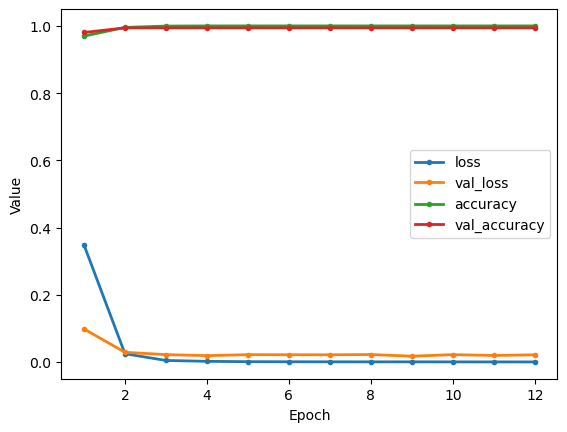

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

10/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

10/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [26]:
report.save()

Report saved as Output/Reports/CPP/report_Z4NYGLG0.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################